In [1]:
import os
import json
from dotenv import load_dotenv
from pydantic import BaseModel
from typing_extensions import TypedDict, Literal, Annotated
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langchain.agents import AgentExecutor
from langgraph.graph import StateGraph, END, add_messages
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langmem import create_manage_memory_tool, create_search_memory_tool
from langgraph.store.memory import InMemoryStore
from IPython.display import Image, display
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

In [2]:
load_dotenv()
os.environ['GOOGLE_API_KEY'] = os.getenv('GEMINI_API_KEY')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

# Perfil do usuário
profile = {
    "name": "Sarah",
    "full_name": "Sarah Chen",
    "user_profile_background": "Engenheira de software sênior liderando uma equipe de 5 desenvolvedores",
}

# Instruções para o prompt
prompt_instructions = {
    "triage_rules": {
        "ignore": "Newsletters, spam, comunicados gerais da empresa",
        "notify": "Membro da equipe doente, notificações do sistema de build, atualizações de status de projeto",
        "respond": "Perguntas diretas de membros da equipe, solicitações de reunião, relatórios de bugs críticos",
    },
    "agent_instructions": """Você é um assistente executivo altamente eficiente. Execute as tarefas solicitadas de forma direta, sem diálogos desnecessários. Responda apenas com a chamada das ferramentas, a menos que seja estritamente necessário fornecer uma resposta textual.

Tarefas:
- Responder ao e-mail de entrada.
- Salvar a tarefa de acompanhamento na memória.
- Sugerir uma próxima ação, como 'Gostaria que eu agendasse uma reunião para discutir isso?'"""
}

In [3]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

# Roteador para classificar a intenção do e-mail
class Router(BaseModel):
    # Raciocínio por trás da classificação
    reasoning: str
    # Classificação do e-mail como 'ignorar', 'notificar' ou 'responder'
    classification: Literal["ignore", "notify", "respond"]

llm_router = llm.with_structured_output(Router)

# Prompt do sistema para a triagem de e-mails
triage_system_prompt = """Você é um assistente de triagem de e-mails.
Classifique os e-mails como 'ignore', 'notify' ou 'respond'.

Regras:
- ignore: {triage_no}
- notify: {triage_notify}
- respond: {triage_email}
"""

# Prompt do usuário, que contém os dados do e-mail
triage_user_prompt = """
De: {author}
Para: {to}
Assunto: {subject}
Corpo da Mensagem:
{email_thread}
"""

In [4]:
# --- 3. Ferramentas ---
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Envia um e-mail para o destinatário especificado com o assunto e conteúdo fornecidos."""
    return json.dumps({"to": to, "subject": subject, "content": content})

@tool
def schedule_meeting(attendees: list[str], subject: str, duration_minutes: int, preferred_day: str) -> str:
    """Agenda uma reunião com os participantes especificados."""
    return f"Reunião '{subject}' agendada para {preferred_day} com {len(attendees)} participantes"

@tool
def check_calendar_availability(day: str) -> str:
    """Verifica os horários disponíveis para o dia fornecido."""
    return f"Horários disponíveis em {day}: 9:00, 14:00, 16:00"

google_embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
store = InMemoryStore(index={"embed": google_embeddings})

manage_memory_tool = create_manage_memory_tool(
    store=store,
    namespace=("email_assistant", "{langgraph_user_id}", "collection")
)
search_memory_tool = create_search_memory_tool(
    store=store,
    namespace=("email_assistant", "{langgraph_user_id}", "collection")
)

agent_system_prompt_memory = """
< Função >
Você é o(a) assistente executivo(a) de {full_name}. Sua prioridade é maximizar o desempenho de {name}.
{instructions}
</ Função >

< Ferramentas >
1. write_email(to, subject, content) - Envia e-mails
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Agenda reuniões
3. check_calendar_availability(day) - Verifica horários disponíveis
4. manage_memory - Armazena informações na memória
5. search_memory - Busca informações na memória
</ Ferramentas >
"""

def create_prompt(state):
    return [
        {"role": "system", "content": agent_system_prompt_memory.format(
            instructions=prompt_instructions["agent_instructions"], **profile
        )},
    ] + state['messages']

tools = [write_email, schedule_meeting, check_calendar_availability, manage_memory_tool, search_memory_tool]

response_agent = create_react_agent(
    model=llm,
    tools=tools,
    prompt=create_prompt,
    store=store
)

In [5]:
# --- 4. Grafo de triagem ---
class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

def triage_router(state: State) -> dict:
    author = state['email_input']['from']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    body = state['email_input']['body']

    system_prompt = triage_system_prompt.format(
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"]
    )
    user_prompt = triage_user_prompt.format(
        author=author,
        to=to,
        subject=subject,
        email_thread=body
    )
    result = llm_router.invoke(
        [{"role": "system", "content": system_prompt},
         {"role": "user", "content": user_prompt}]
    )

    if result.classification == "respond":
        message_content = json.dumps({
            "sender": author,
            "recipient": to,
            "subject": subject,
            "body": body
        })
        return {
            "messages": [
                HumanMessage(content=f"Respond to the email {message_content}")
            ],
            "__next__": "response_agent"
        }
    elif result.classification in ["ignore", "notify"]:
        return {"__next__": END}
    else:
        raise ValueError(f"Invalid classification: {result.classification}")

In [6]:
# --- 5. Construção do grafo ---
builder = StateGraph(State)
builder.add_node("triage_router", triage_router)
builder.add_node("response_agent", response_agent)
builder.add_node("tool_node", ToolNode(tools))
builder.set_entry_point("triage_router")

# Condições
builder.add_conditional_edges(
    "triage_router",
    lambda state: state.get("__next__", None),
    {"response_agent": "response_agent", "END": END}
)

def route_to_tools(state):
    last_message = state["messages"][-1]
    if getattr(last_message, "tool_calls", None):
        return "tool_node"
    return END

builder.add_conditional_edges(
    "response_agent",
    route_to_tools,
    {"tool_node": "tool_node", END: END}
)
builder.add_edge("tool_node", "response_agent")

email_agent = builder.compile()


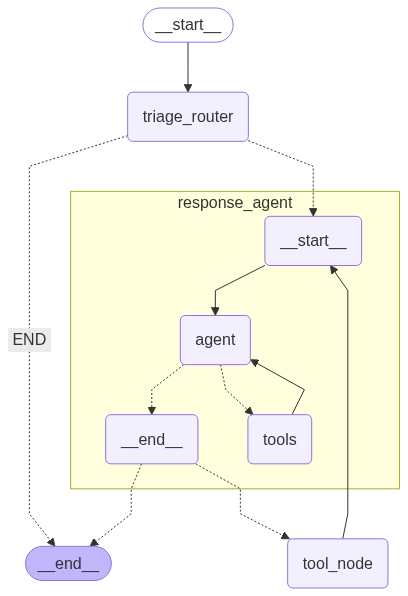

In [7]:
# Gera a imagem do grafo em formato PNG
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [8]:
# --- 6. Human-in-the-loop ---
def human_in_the_loop_schedule(email_sender, email_recipient, email_subject):
    # Checa memória se já há reunião
    search_results = search_memory_tool.invoke(
        {"query": f"Reunião agendada para {email_sender}"},
        config=config
    )
    if isinstance(search_results, str):
        # retorna string, transforma em dict vazio
        search_results = {}

    if search_results.get("results"):
        email_content = write_email.invoke(
            {
                "to": email_sender,
                "subject": f"Re: {email_subject}",
                "content": "Olá, acabei de agendar uma conversa contigo para discutirmos esse assunto."
            },
            config=config
        )
        print("================== Tool Message ==================")
        print(f"Name: write_email\nContent: {email_content}")
        return

    decision = input(f"Deseja agendar uma reunião para discutir o pedido de {email_sender}? (sim/não): ").strip().lower()
    
    if decision == "sim":
        meeting_output = schedule_meeting.invoke(
            {
                "attendees": [email_recipient.split('<')[0].strip(), email_sender.split('<')[0].strip()],
                "subject": f"Acompanhamento do pedido de {email_sender}",
                "duration_minutes": 30,
                "preferred_day": "amanhã"
            },
            config=config
        )
        print("================== Tool Message ==================")
        print(f"Name: schedule_meeting\nContent: {meeting_output}")

        memory_output = manage_memory_tool.invoke(
            {"action": "create", "content": f"Reunião agendada para discutir o pedido de {email_sender}"},
            config=config
        )
        print("================== Tool Message ==================")
        print(f"Name: manage_memory\nContent: {memory_output}")

        email_content = write_email.invoke(
            {
                "to": email_sender,
                "subject": f"Re: {email_subject}",
                "content": "Já agendei uma reunião contigo para discutirmos esse assunto."
            },
            config=config
        )
        print("================== Tool Message ==================")
        print(f"Name: write_email\nContent: {email_content}")

    else:
        email_content = write_email.invoke(
            {
                "to": email_sender,
                "subject": f"Re: {email_subject}",
                "content": "Estou acompanhando seu pedido e entrarei em contato assim que houver novidades."
            },
            config=config
        )
        print("================== Tool Message ==================")
        print(f"Name: write_email\nContent: {email_content}")

        memory_output = manage_memory_tool.invoke(
            {"action": "create", "content": f"E-mail de acompanhamento enviado para {email_sender}"},
            config=config
        )
        print("================== Tool Message ==================")
        print(f"Name: manage_memory\nContent: {memory_output}")

In [9]:
# --- 7. Exemplo de execução ---
config = {"configurable": {"langgraph_user_id": "lance"}}

# Pré-popula a memória
initial_memory_content = "Acompanhamento necessário: Alice Smith perguntou sobre os endpoints de API ausentes na documentação do serviço de autenticação (/auth/refresh e /auth/validate). Sarah precisa revisar e esclarecer se eles foram intencionalmente omitidos ou se a documentação precisa de atualização."
manage_memory_tool.invoke({"action": "create", "content": initial_memory_content}, config=config)

email_input = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "Sarah Chen <sarah.chen@company.com>",
    "subject": "Acompanhamento",
    "body": "Olá Sarah, como está minha solicitação?"
}

# 1️⃣ Agente responde
response = email_agent.invoke({"email_input": email_input}, config=config)
for msg in response["messages"]:
    if isinstance(msg, ToolMessage):
        print("================== Mensagem da Ferramenta ==================")
        print(f"Nome: {msg.name}\nConteúdo: {msg.content}")

# 2️⃣ Human-in-the-loop
human_in_the_loop_schedule(email_input["from"], email_input["to"], email_input["subject"])

================== Mensagem da Ferramenta ==================
Nome: write_email
Conteúdo: {"to": "alice.smith@company.com", "subject": "Re: Acompanhamento", "content": "Ol\u00e1 Alice,\n\nObrigado por seu e-mail. Estou acompanhando sua solicita\u00e7\u00e3o e atualizarei voc\u00ea em breve.\n\nAtenciosamente,\nSarah"}
================== Mensagem da Ferramenta ==================
Nome: manage_memory
Conteúdo: created memory 8a41b5b7-7e16-4291-93a2-0e38f98ef60b
================== Mensagem da Ferramenta ==================
Nome: search_memory
Conteúdo: [{"namespace":["email_assistant","lance","collection"],"key":"9a5c7e13-ba6e-4791-b60d-5f1f7b8b34fa","value":{"content":"Acompanhamento necessário: Alice Smith perguntou sobre os endpoints de API ausentes na documentação do serviço de autenticação (/auth/refresh e /auth/validate). Sarah precisa revisar e esclarecer se eles foram intencionalmente omitidos ou se a documentação precisa de atualização."},"created_at":"2025-08-21T12:35:54.752828+00: